In [1]:
import numpy as np
import pandas as pd

import os
import re

import datetime
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pvlib


In [2]:
data_pt = os.path.join('data', "222628_32.73_-117.18_2012.csv")

lat, lon = 32.73, -117.18
offset = 7

In [3]:
nsrdb = pd.read_csv(data_pt, skiprows=2, usecols=['Year', 'Month', 'Day', 'Hour', 'Minute', 'Temperature', 'DHI', 'GHI',
       'DNI', 'Surface Albedo', 'Wind Speed', 'Pressure'])
local_index = pd.DatetimeIndex(nsrdb['Year'].astype(str) + '-' + nsrdb['Month'].astype(str) +
                             '-' + nsrdb['Day'].astype(str) + ' ' + nsrdb['Hour'].astype(str) +
                               ':' + nsrdb['Minute'].astype(str))
nsrdb.set_index(local_index, inplace=True)

Plot NSRDB data

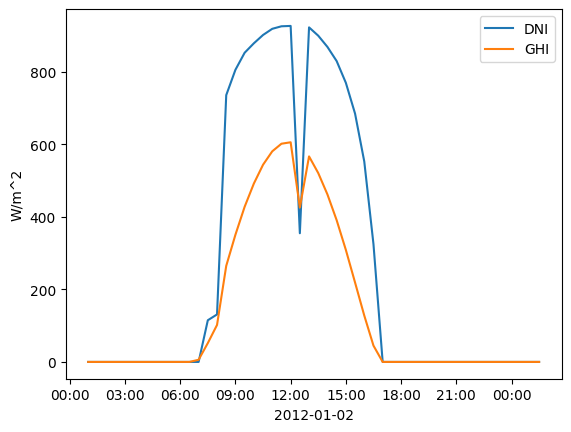

In [4]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = nsrdb.index[50:100]
ax.plot(idx, nsrdb.loc[idx, "DNI"], label='DNI')
ax.plot(idx, nsrdb.loc[idx, "GHI"], label='GHI')
ax.set_ylabel('W/m^2')
ax.set_xlabel(idx[0].date())
ax.legend()

Interpolating NSRDB data

In [4]:
start_date = str(nsrdb.index[0])
end_date = str(nsrdb.index[-1])

times_interp = pd.date_range(start_date, end_date, freq='5min')

nsrdb_interpolated = pd.DataFrame(index=times_interp)
nsrdb_interpolated['dni_extra'] = pvlib.irradiance.get_extra_radiation(nsrdb_interpolated.index)
times_float = times_interp.to_numpy().astype(float)
for i in nsrdb.columns:
    cs = CubicSpline(nsrdb.index.to_numpy().astype(float), nsrdb[i].values)
    nsrdb_interpolated[i] = cs(times_float)
    nsrdb_interpolated[i] = np.maximum(nsrdb_interpolated[i], 0)

Plot interpolated vs. original

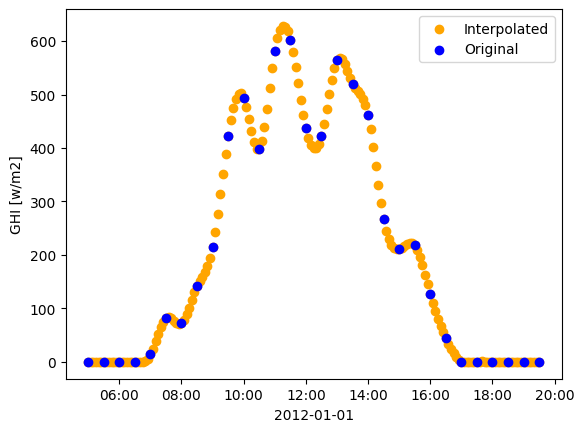

In [6]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = nsrdb.index[10:40]
start = idx[0]
end = idx[-1]

interpolated_idx = nsrdb_interpolated[start:end].index
ax.scatter(interpolated_idx, nsrdb_interpolated.loc[interpolated_idx, "GHI"], label='Interpolated', c='orange')

ax.scatter(idx, nsrdb.loc[idx, "GHI"], label='Original', c='b')
ax.legend()
ax.set_ylabel('GHI [w/m2]')
ax.set_xlabel(end.date());

Get solar position

In [5]:

loc = pvlib.location.Location(lat,lon, altitude=0)
fake_index = pd.date_range(datetime.datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=-offset),
                           datetime.datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S') + pd.Timedelta(hours=offset), freq='5min')
solar_position = loc.get_solarposition(times=fake_index)
solar_position.set_index(solar_position.index.shift(periods=-offset, freq = '1h'), inplace = True)
solar_position = solar_position.loc[times_interp]
data = pd.concat([nsrdb_interpolated, solar_position], axis=1)

Plot solar position

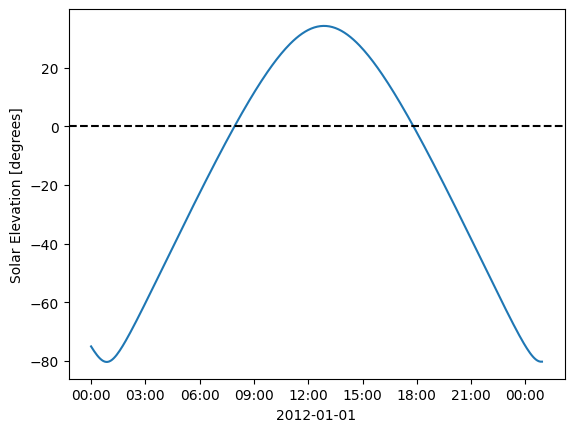

In [8]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = data.index[:300]
ax.plot(idx, data.loc[idx, "elevation"])
ax.set_ylabel('Solar Elevation [degrees]')
ax.set_xlabel(idx[0].date())
ax.axhline(0, ls='--', c='k');

Check for DST offsets

In [9]:
def get_average_solar_noon(elevation):
    
    '''
    I use this to check that there is not daylight-savings related shifts
    in my data. For each day in the pd.Series index, I get the pd.Timestamp
    associated with solar noon (defined as the maximum of solar elevation).
    You could also do this using groupby functionality.
    The tricky part about this is using np.mean with Timestamp objects, as
    np.mean does not take Timestamp objects. I do this by converting the
    Timestamp to a float, averaging them, and then converting back to a
    Timestamp. Since I only want the average time, and I don't care about the
    date, I assign the same date to all Timestamps. 
    
    Parameters
    ----------
    elevation : pd.Series
    
    Returns
    -------
    my_dict : dict
    
    '''
    
    days = np.unique(elevation.index.map(lambda x: x.date()))
    list_of_solar_noons = []
    
    # Get datetime for each day's solar noon
    for d in days:
        temp = elevation[d: d + datetime.timedelta(days=1)]
        idx = np.ravel(np.argmax(temp))[0]
        solar_noon = pd.to_datetime(temp.index[idx])
        list_of_solar_noons.append(solar_noon)
        
    my_index = pd.to_datetime(list_of_solar_noons)
    
    # Get your local machine's UTC offset - needed to go back and forth
    # between Timestamp and float
    ts = pd.to_datetime(my_index[0].replace(year=1970, month=1, day=1)).timestamp()
    utc_offset = datetime.datetime.fromtimestamp(ts) - datetime.datetime.utcfromtimestamp(ts)
    shift = utc_offset.total_seconds() / 3600
    
    my_dict = {}
    months = np.unique(elevation.index.map(lambda x: x.date().month))
    for m in months:
        sub_index = my_index[my_index.month == m]
        # Get numpy timestamp
        times = sub_index.map(lambda x: x.replace(year=1970, month=1, day=1).timestamp())
        avg = (datetime.datetime.fromtimestamp(np.mean(times)) + datetime.timedelta(hours=-shift)).time()
        my_dict[m] = avg
    return my_dict

In [10]:
noons = get_average_solar_noon(data['elevation'])
noons

{np.int64(1): datetime.time(12, 57, 44, 516129),
 np.int64(2): datetime.time(13, 3, 26, 896552),
 np.int64(3): datetime.time(12, 57, 25, 161290),
 np.int64(4): datetime.time(12, 48, 20),
 np.int64(5): datetime.time(12, 45),
 np.int64(6): datetime.time(12, 49, 20),
 np.int64(7): datetime.time(12, 55),
 np.int64(8): datetime.time(12, 52, 44, 516129),
 np.int64(9): datetime.time(12, 43, 20),
 np.int64(10): datetime.time(12, 34, 21, 290323),
 np.int64(11): datetime.time(12, 33, 40),
 np.int64(12): datetime.time(12, 44, 50, 322581)}

Get solar tracking angles

In [7]:
axis_azimuth = 180
gcr = 0.4

backtracking_angles = pvlib.tracking.singleaxis(
        apparent_zenith=data['apparent_zenith'],
        apparent_azimuth=data['azimuth'],
        axis_tilt=0,
        axis_azimuth=axis_azimuth,
        max_angle=90,
        backtrack=True,
        gcr=gcr)

Transpose irradiance measurements to plane-of-array

In [7]:
poa = pvlib.irradiance.get_total_irradiance(backtracking_angles['surface_tilt'],
                                            backtracking_angles['surface_azimuth'],
                                            data['zenith'], data['azimuth'],
                                            data['DNI'], data['GHI'], data['DHI'],
                                            data['dni_extra'], model='haydavies')

aoi = pvlib.irradiance.aoi(backtracking_angles['surface_tilt'],
                            backtracking_angles['surface_azimuth'],
                            data['zenith'], data['azimuth'])
am_rel = pvlib.atmosphere.get_relative_airmass(data['zenith'])
am_abs = pvlib.atmosphere.get_absolute_airmass(am_rel, data['Pressure'])


Plot plane-of-array irradiance

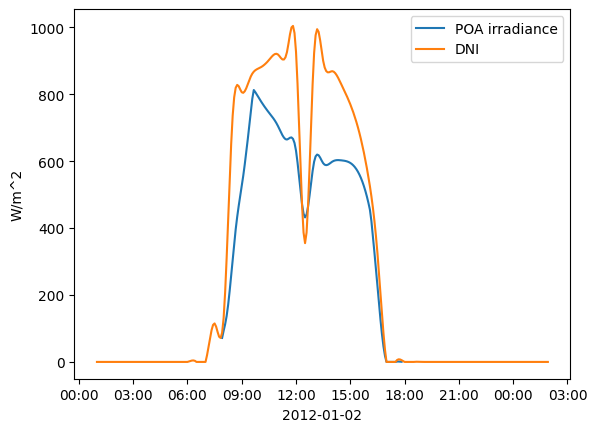

In [19]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = data.index[300:600]
ax.plot(idx, poa.loc[idx, "poa_global"], label='POA irradiance')
ax.plot(idx, data.loc[idx, "DNI"], label='DNI')
ax.set_ylabel('W/m^2')
ax.legend()
ax.set_xlabel(idx[0].date());

Set panel specs

In [8]:
mod_db_cec = pvlib.pvsystem.retrieve_sam('CECMod')
mod_db_sandia = pvlib.pvsystem.retrieve_sam('SandiaMod')
module_cec = mod_db_cec['Canadian_Solar_Inc__CS6K_300M']
module_sandia = mod_db_sandia['Canadian_Solar_CS6X_300M__2013_']


stc_mod_p = module_cec['STC']
# This is provided as a %
Gpmp = module_cec['gamma_r']/100
temp_ref=25.0

temp_model = 'sapm'
temp_model_material = 'open_rack_glass_polymer'
temperature_model_parameters = pvlib.temperature.TEMPERATURE_MODEL_PARAMETERS[temp_model][temp_model_material]

Model cell temperature and effective irradiance

In [9]:
t_cell = pvlib.temperature.sapm_cell(poa['poa_global'],
                                    data['Temperature'].values,
                                    data['Wind Speed'].values,
                                    **temperature_model_parameters)

# Effective Irradiance
eff_irr = pvlib.pvsystem.sapm_effective_irradiance(poa['poa_direct'],
                                                    poa['poa_diffuse'],
                                                    am_abs, aoi, module_sandia)

Plot effective irradiance

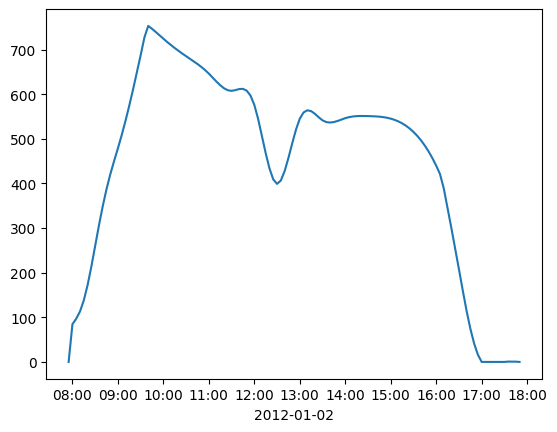

In [28]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = data.index[300:600]
ax.plot(idx, eff_irr[idx])
ax.set_xlabel(idx[0].date());

Model power output from a single panel

In [10]:

# Power is linear with irradiance in PVWatts
pvw = pvlib.pvsystem.pvwatts_dc(eff_irr, t_cell, stc_mod_p, -0.002) 
    

Plot power

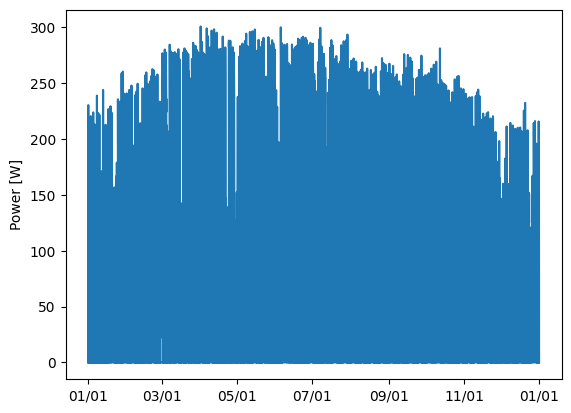

In [136]:
date_form = DateFormatter("%m/%d")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

idx = data.index
ax.plot(idx, pvw[idx])
ax.set_ylabel('Power [W]');

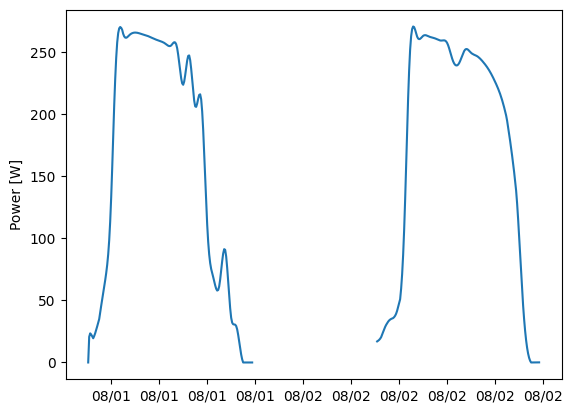

In [137]:
date_form = DateFormatter("%m/%d")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

start = '2012-08-01 00:00:00'
end = '2012-08-02 23:50:00'
idx = data[start:end].index
ax.plot(idx, pvw[idx])
ax.set_ylabel('Power [W]');

Load in load data

In [129]:
load_pt = os.path.join('data', "Project 2 - Load Profile.csv")
load = pd.read_csv(load_pt)
load = load[:105408]

Redo index

In [130]:
new_idx = []
for i in load.index: 
    string = load['Datetime'][i]
    match = re.search(r'(\d+)/(\d+)/(\d+)\W+(\d+):(\d+)', string)
    new_datetime = datetime.datetime(2012, int(match.group(1)), int(match.group(2)), int(match.group(4)), int(match.group(5)))
    new_idx.append(new_datetime)
load.set_index(pd.DatetimeIndex(new_idx), inplace=True)
load = pd.Series(load['Load (MW)'])*1000**2

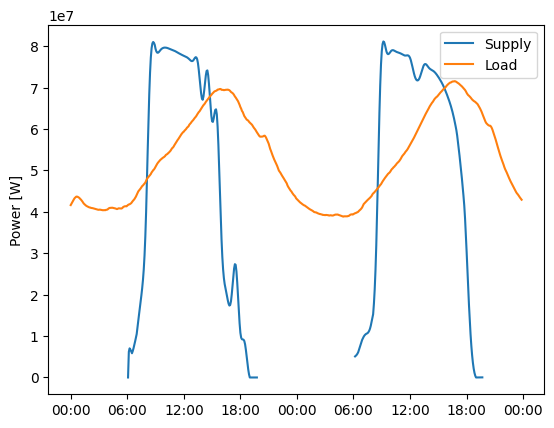

In [135]:
date_form = DateFormatter("%H:%M")
    
fig, ax = plt.subplots()
ax.xaxis.set_major_formatter(date_form)

start = '2012-08-01 00:00:00'
end = '2012-08-02 23:50:00'
idx = data[start:end].index
ax.plot(idx, pvw[idx]*300000, label='Supply')
ax.plot(idx, load[idx], label='Load')
ax.set_ylabel('Power [W]')
ax.legend();